In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from scipy.optimize import curve_fit
from scipy.stats import variation
from statistics import mean, median

Paste your 96 well format OD data from Excel between the upper ''' and lower '''.

In [2]:
rawData = '''
0.0852	0.0909	1.0152	1.0193	1.4698	1.4346	1.3914	1.3189	1.0561	1.0315	0.9776	0.8982
0.1998	0.2059	1.3113	1.3123	1.4003	1.4687	1.1744	1.1172	1.3803	1.3779	1.0289	0.9687
0.5419	0.5775	1.3019	1.268	1.5094	1.4188	1.3647	1.3623	1.2337	1.1531	1.0065	1.006
1.3515	1.2988	1.2734	1.168	1.2681	1.234	1.1909	1.1687	1.4781	1.4622	1.2507	1.2105
1.7263	1.8067	1.4484	1.3741	1.2717	1.2308	1.1849	1.195	1.2694	1.2222	1.3079	1.2981
1.9898	2.0525	1.37	1.3244	1.1819	1.1219	1.4149	1.3923	1.5198	1.4659	1.2615	1.3318
1.2145	1.2886	1.4299	1.3123	1.4536	1.4983	1.3706	1.3367	1.1608	1.1361	1.4381	1.331
0.5247	0.5226	1.3055	1.215	1.5753	1.6669	1.2898	1.3052	1.2512	1.2417	1.1577	1.2308
'''
row_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
column_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

plateTemplate = pd.DataFrame(index = row_list, columns = column_list)

rawData = pd.read_table(io.StringIO(rawData), delim_whitespace=True, names=plateTemplate.columns)
rawData.index = plateTemplate.index
rawData

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.0852,0.0909,1.0152,1.0193,1.4698,1.4346,1.3914,1.3189,1.0561,1.0315,0.9776,0.8982
B,0.1998,0.2059,1.3113,1.3123,1.4003,1.4687,1.1744,1.1172,1.3803,1.3779,1.0289,0.9687
C,0.5419,0.5775,1.3019,1.2680,1.5094,1.4188,1.3647,1.3623,1.2337,1.1531,1.0065,1.0060
D,1.3515,1.2988,1.2734,1.1680,1.2681,1.2340,1.1909,1.1687,1.4781,1.4622,1.2507,1.2105
E,1.7263,1.8067,1.4484,1.3741,1.2717,1.2308,1.1849,1.1950,1.2694,1.2222,1.3079,1.2981
F,1.9898,2.0525,1.3700,1.3244,1.1819,1.1219,1.4149,1.3923,1.5198,1.4659,1.2615,1.3318
G,1.2145,1.2886,1.4299,1.3123,1.4536,1.4983,1.3706,1.3367,1.1608,1.1361,1.4381,1.3310
H,0.5247,0.5226,1.3055,1.2150,1.5753,1.6669,1.2898,1.3052,1.2512,1.2417,1.1577,1.2308


Paste your 96 well format plate template between the upper ''' and lower '''.

In [3]:
plateLayout = '''
St01	St01	S01	S01	S09	S09	S17	S17	S25	S25	S33	S33
St02	St02	S02	S02	S10	S10	S18	S18	S26	S26	S34	S34
St03	St03	S03	S03	S11	S11	S19	S19	S27	S27	S35	S35
St04	St04	S04	S04	S12	S12	S20	S20	S28	S28	S36	S36
St05	St05	S05	S05	S13	S13	S21	S21	S29	S29	S37	S37
St06	St06	S06	S06	S14	S14	S22	S22	S30	S30	S38	S38
Co01	Co01	S07	S07	S15	S15	S23	S23	S31	S31	S39	S39
Co02	Co02	S08	S08	S16	S16	S24	S24	S32	S32	S40	S40
'''

plateLayout = pd.read_table(io.StringIO(plateLayout), delim_whitespace=True, names=plateTemplate.columns)
plateLayout.index = plateTemplate.index
plateLayout

,1,2,3,4,5,6,7,8,9,10,11,12
A,St01,St01,S01,S01,S09,S09,S17,S17,S25,S25,S33,S33
B,St02,St02,S02,S02,S10,S10,S18,S18,S26,S26,S34,S34
C,St03,St03,S03,S03,S11,S11,S19,S19,S27,S27,S35,S35
D,St04,St04,S04,S04,S12,S12,S20,S20,S28,S28,S36,S36
E,St05,St05,S05,S05,S13,S13,S21,S21,S29,S29,S37,S37
F,St06,St06,S06,S06,S14,S14,S22,S22,S30,S30,S38,S38
G,Co01,Co01,S07,S07,S15,S15,S23,S23,S31,S31,S39,S39
H,Co02,Co02,S08,S08,S16,S16,S24,S24,S32,S32,S40,S40


Check that the standards values listed below are correct.

In [4]:
# In the [] after pd.Series, input the standard concentrations. Number separated by a comma.
# In the [] after index=, input the corresponding labels for each standard. Labels in 'quotes' separated by a comma.
standardConc = pd.Series([0, .25, 1, 4, 16, 64], index=['St01', 'St02', 'St03', 'St04', 'St05', 'St06'], name='Conc')

In [5]:
wellID = []
sampleID = []
wellOD = []
for row_data in row_list:
    for column_data in column_list:
        wellID.append(row_data + column_data)
        sampleID.append(plateLayout.at[row_data, column_data])
        wellOD.append(rawData.at[row_data, column_data])

dataTable = pd.DataFrame({'Sample ID':sampleID, 'OD':wellOD}, index=wellID)

standardCurve = dataTable.groupby('Sample ID').mean()
standardCurve = pd.concat([standardConc, standardCurve], axis=1, join_axes=[standardConc.index])
standardCurve

,Conc,OD
St01,0.00,0.08805
St02,0.25,0.20285
St03,1.00,0.55970
St04,4.00,1.32515
St05,16.00,1.76650
St06,64.00,2.02115


In [6]:
x_list = standardCurve['Conc'].tolist()
y_list = standardCurve['OD'].tolist()

# This orders the coordinate pairs from lowest analyte concentration to highest.
standardCurve = sorted(zip(x_list, y_list))

# This strips out any 0s from the x and y lists and replaces them with 0.001.
x_list = [x_val if x_val != 0 else 0.001 for x_val in [x[0] for x in standardCurve]]
y_list = [y_val if y_val != 0 else 0.001 for y_val in [y[1] for y in standardCurve]]

[ 0.07831873  1.12810066  2.61054468  2.04267913] [[ 0.00203928  0.00293957  0.00453506 -0.0006826 ]
 [ 0.00293957  0.01558447 -0.00818953 -0.00532296]
 [ 0.00453506 -0.00818953  0.0853542   0.01094127]
 [-0.0006826  -0.00532296  0.01094127  0.00385694]]
(array([ 0.07831873,  1.12810066,  2.61054468,  2.04267913]), array([[ 0.00203928,  0.00293957,  0.00453506, -0.0006826 ],
       [ 0.00293957,  0.01558447, -0.00818953, -0.00532296],
       [ 0.00453506, -0.00818953,  0.0853542 ,  0.01094127],
       [-0.0006826 , -0.00532296,  0.01094127,  0.00385694]]))
0.0783187315213 1.12810065789 2.610544677 2.04267912524


[0.1, 640.0, 0, 2.42538]

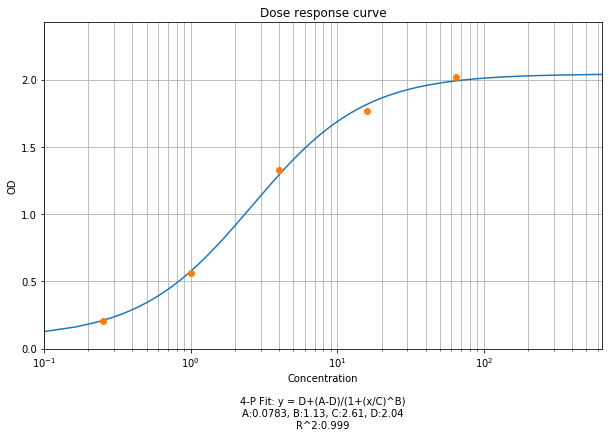

In [7]:
def logistic4(x, A, B, C, D):
    """4PL logistic equation."""
    return D + (A-D)/(1 + (x/C)**B)

def maxSlope(x_list, y_list):
    x_list = [math.log10(l) for l in [float(i) for i in x_list]]
    coordinates = zip(x_list, y_list)
    x_1, y_1 = 1, y_list[0] #Trying to make sure first calculation always has zero on top and non-zero on bottom
    slopeList = []
    for x_2, y_2 in coordinates:
        slopeList.append(abs((y_2 - y_1)/(x_2 - x_1))) #Parameter B should always be positive so using abs
        x_1, y_1 = x_2, y_2
    return(max(slopeList))

# Initial guess for parameters
p0 = [y_list[0], maxSlope(x_list,y_list), median(x_list), y_list[-1]]

# Fit equation using least squares optimization
popt, pcov = curve_fit(logistic4, x_list, y_list, p0, bounds=(0, np.inf))
print(popt, pcov)
print(curve_fit(logistic4, x_list, y_list, p0, bounds=(0, np.inf)))
print(*popt)

# Calculate R^2
r_squared = (1 
             - sum([(y_meas - y_calc)**2 for y_meas, y_calc in zip(y_list, [logistic4(x_std, *popt) for x_std in x_list])])
             / sum([(y_meas - mean(y_list))**2 for y_meas in y_list]))

xCont = np.linspace(0.1, 10*max(x_list), 10000)
fittedData=[logistic4(xVal, *popt) for xVal in xCont]
fig1 = plt.figure(figsize=(10,6))
ax=fig1.add_subplot(1,1,1)
ax.plot(xCont, fittedData)
ax.set_ylabel("OD")
ax.set_xlabel("""Concentration

4-P Fit: y = D+(A-D)/(1+(x/C)^B)
A:{1:0.3g}, B:{2:0.3g}, C:{3:0.3g}, D:{4:0.3g}
R^2:{0:0.3g}""".format(r_squared, *popt))
ax.grid(True, which='both')
ax.set_title("Dose response curve")
plt.xscale('log')
plt.plot(x_list, y_list, 'o')
plt.axis([0.1, 10*max(x_list), 0, 1.2*max(y_list)])

In [8]:
def backcalc4(y, A, B, C, D):
    #if ((A - D)/(y - D)) - 1 < 0:
    #    return 'NA'
    #return ((((A - D)/(y - D)) - 1)**(1/B)) * C
    #I had issues with a negative number where it is 'impossible' to exist so I
    #rewrote the formula to use complex numbers. I am still iffy about this solution...
    return (cmath.exp((1/B) * cmath.log((((A - D)/(y - D)) - 1)))) * C

backcalcConc = []
for data in wellOD:
    backcalcConc.append(backcalc4(data, *popt))
    
dataTable = pd.DataFrame({'Sample ID':sampleID, 'OD':wellOD, 'CalcConc':backcalcConc}, index=wellID)
groupedDataTable = dataTable.groupby('Sample ID')
groupedDataTable['OD', 'CalcConc'].agg([np.mean, variation])

OD                                   CalcConc  \
              mean variation                             mean   
Sample ID                                                       
Co01       1.25155  0.029603               (3.71290773861+0j)   
Co02       0.52365  0.002005              (0.879751391432+0j)   
S01        1.01725  0.002015               (2.41439349565+0j)   
S02        1.31180  0.000381               (4.15153764233+0j)   
S03        1.28495  0.013191               (3.94576797749+0j)   
S04        1.22070  0.043172               (3.51484908266+0j)   
S05        1.41125  0.026324                (5.0835775756+0j)   
S06        1.34720  0.016924               (4.45450266988+0j)   
S07        1.37110  0.042885               (4.70942939946+0j)   
S08        1.26025  0.035906               (3.77985521598+0j)   
S09        1.45220  0.012120               (5.52433258157+0j)   
S10        1.43450  0.023841               (5.33442985918+0j)   
S11        1.46410  0.030941               (5.70257484031+0j)   
S12        1.25105  0.013629               (3.70081617076+0j)   
S13        1.25125  0.016344               (3.70321843091+0j)   
S14        1.15190  0.026044               (3.08536736513+0j)   
S15        1.47595  0.015143               (5.82113662961+0j)   
S16        1.62110  0.028252               (8.34776204362+0j)   
S17        1.35515  0.026750               (4.53470749779+0j)   
S18        1.14580  0.024961               (3.05080905107+0j)   
S19        1.36350  0.000880               (4.59473633087+0j)   
S20        1.17980  0.009408               (3.24205634895+0j)   
S21        1.18995  0.004244               (3.30237598135+0j)   
S22        1.40360  0.008051               (4.98516175405+0j)   
S23        1.35365  0.012522               (4.50901121924+0j)   
S24        1.29750  0.005934               (4.03943045391+0j)   
S25        1.04380  0.011784               (2.53363580578+0j)   
S26        1.37910  0.000870               (4.74079524498+0j)   
S27        1.19340  0.033769                (3.3337555643+0j)   
S28        1.47015  0.005408               (5.73863386731+0j)   
S29        1.24580  0.018944               (3.66664399073+0j)   
S30        1.49285  0.018053               (6.04921705255+0j)   
S31        1.14845  0.010754               (3.06185218614+0j)   
S32        1.24645  0.003811               (3.66694201388+0j)   
S33        0.93790  0.042329               (2.09463058929+0j)   
S34        0.99880  0.030136               (2.33830042007+0j)   
S35        1.00625  0.000248               (2.36679520304+0j)   
S36        1.23060  0.016333               (3.56286003027+0j)   
S37        1.30300  0.003761               (4.08196606624+0j)   
S38        1.29665  0.027108               (4.04394427547+0j)   
S39        1.38455  0.038677               (4.83222434542+0j)   
S40        1.19425  0.030605               (3.33710602936+0j)   
St01       0.08805  0.032368             (0.0236360774041+0j)   
St02       0.20285  0.015036               (0.23990285638+0j)   
St03       0.55970  0.031803              (0.963267665022+0j)   
St04       1.32515  0.019885                (4.2677105527+0j)   
St05       1.76650  0.022757               (13.2626215294+0j)   
St06       2.02115  0.015511  (-103.238716313+50.1762117764j)   

                                             
                                  variation  
Sample ID                                    
Co01                    (0.069435106525+0j)  
Co02                  (0.00270279374704+0j)  
S01                   (0.00370754451156+0j)  
S02                  (0.000965750897679+0j)  
S03                    (0.0322744707143+0j)  
S04                     (0.097522604053+0j)  
S05                    (0.0767752100325+0j)  
S06                    (0.0449704421581+0j)  
S07                     (0.117611362004+0j)  
S08                    (0.0850707072747+0j)  
S09                    (0.0377678916199+0j)  
S10                    (0.0721340360682+0j)  
S11       